In [2]:
! pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 1.2 MB/s eta 0:00:0000:0100:01m


# Code to load gridded observational data

In [4]:
## For Gridded

import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

meta = pd.read_excel('SEWAA-data.xlsx',sheet_name='Gridded',index_col=0,nrows=2)
data = pd.read_excel('SEWAA-data.xlsx',sheet_name='Gridded',index_col=0,skiprows=[1,2])

ds = data.to_xarray().rename({'ID':'time'})

# Not sure if this is the best way but it works
ds['time'] = np.array([t[:4]+'-'+t[4:6]+'-'+t[-2:] for t in ds['time'].values.astype(str)],dtype='datetime64[ns]')

#ds = ds.assign_coords({'latitude':meta.values[0],'longitude':meta.values[1]})

#ds


# Code to load point observational data

In [29]:
def parser(vals):
    vals_temp = np.zeros_like(vals.flatten())
    for i, val in enumerate(vals.flatten()):
        if type(val) is str:
            try:
                vals_temp[i] = val.replace('..','.').replace(" ","").astype(np.float64)
            except:
                vals_temp[i] = 0
            
        else:
            vals_temp[i] = val
    
    return vals_temp.astype(np.float64)
    
file_path='SEWAA-data.xlsx'
sheets = pd.ExcelFile(file_path).sheet_names

meta = []
ds = []
for sheet in sheets[:-1]:

    df_meta = pd.read_excel('SEWAA-data.xlsx',sheet_name=sheet)
    columns = df_meta.columns
    region = np.unique(df_meta['Station_Name'])
    region = [region[0].split(" ")[0]]
    try:
        lat = np.unique(df_meta['lat'])
        lon = np.unique(df_meta['lon'])
    except:
        lat = np.unique(df_meta['Lat'])
        lon = np.unique(df_meta['Lon'])
    meta.append(xr.DataArray(data=np.hstack((lon,lat))[None,:],
                            dims = ['region','ID'],
                            coords = {'region':region,
                                     'ID':['lon','lat']}))
    year_idx = np.squeeze(np.argwhere(columns=='Year'))
    use_cols = np.arange(33)+year_idx
    df = pd.read_excel('SEWAA-data.xlsx',sheet_name=sheet,
                       index_col=[0,1],usecols=use_cols)
    data = []
    times = []
    for year,month in df.index.values:
        if month!=12:
            times.append(np.arange(f'{year}-{month:02}-01',f'{year}-{month+1:02}-01',
                                   np.timedelta64(1,'D'),dtype='datetime64[ns]'))
        else:
            times.append(np.arange(f'{year}-{month:02}-01',f'{year+1}-01-01',
                                   np.timedelta64(1,'D'),dtype='datetime64[ns]'))

        no_of_days = len(times[-1])

        data.append(parser(df.loc[[(year,month)]].values).reshape(-1,1)[:no_of_days])


    times = np.hstack((times))
    data = np.vstack((data))

    ds.append(xr.DataArray(data=data,
                           dims = ['time','region'],
                           coords = {
                               'time':times,
                               'region':region,
                           }))

meta = xr.concat(meta,'region').to_dataset('region')
ds = xr.concat(ds,'region').to_dataset('region')


In [26]:
[var for var in ds.data_vars]

['KABETE', 'EASTLEIGH', 'J.K.I.A.', 'DAGORETTI', 'NGONG', 'WILSON']

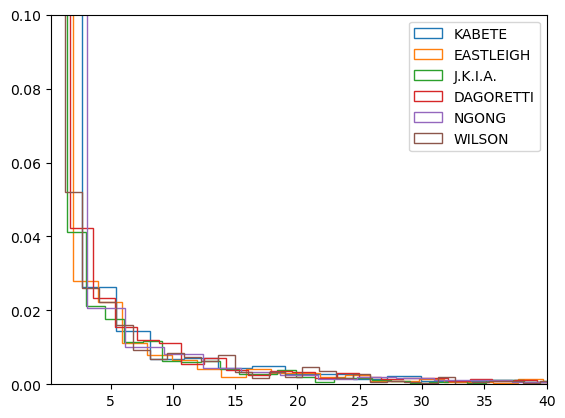

In [14]:
import matplotlib.pyplot as plt

for region in ds.data_vars:

    plt.hist(ds[region].values,bins=50,density=True,histtype='step',label=region)
    plt.xlim(0.2,40)
    plt.ylim(0,0.1)
    
plt.legend()



# Load in IMERG, cGAN and IFS

In [5]:
import glob

files = glob.glob('datasets/IMERG*_Nairobi.zarr')
ds_IMERG = xr.open_mfdataset(files,engine="zarr")

files = glob.glob('datasets/cGAN_50*_Nairobi.zarr')
ds_cGAN_50 = []
for file in files:
    ds_temp = xr.open_dataset(file,engine="zarr")
    if type(ds_temp['time'].values[0]) == np.float32:
        ds_temp['time'] = (ds_temp['time'].astype('datetime64[ns]')+np.timedelta64(1,'h')).astype('datetime64[D]').astype('datetime64[ns]')
    ds_cGAN_50.append(ds_temp) 
ds_cGAN_50 = xr.concat(ds_cGAN_50, 'time').sortby('time')

files = glob.glob('datasets/cGAN_2*_Nairobi.zarr')
ds_cGAN = []
for file in files:
    ds_temp = xr.open_dataset(file,engine="zarr")
    if type(ds_temp['time'].values[0]) == np.float32:
        ds_temp['time'] = (ds_temp['time'].astype('datetime64[ns]')+np.timedelta64(1,'h')).astype('datetime64[D]').astype('datetime64[ns]')
    ds_cGAN.append(ds_temp) 
ds_cGAN = xr.concat(ds_cGAN, 'time').sortby('time')

files = glob.glob('datasets/IFS*_Nairobi.zarr')
ds_IFS = []
for file in files:
    ds_IFS.append(xr.open_zarr(file).drop_duplicates('time',keep='last'))

ds_IFS = xr.concat(ds_IFS,'time')                


In [88]:
ds_cGAN

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 1234, member: 50, latlon: 6)
Coordinates:
    latitude   (latlon) float64 48B dask.array<chunksize=(6,), meta=np.ndarray>
  * latlon     (latlon) int64 48B 0 1 2 3 4 5
    longitude  (latlon) float64 48B dask.array<chunksize=(6,), meta=np.ndarray>
  * member     (member) int32 200B 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50
  * time       (time) datetime64[ns] 10kB 2018-01-01 2018-01-02 ... 2024-05-29
Data variables:
    Nairobi    (time, member, latlon) float32 1MB dask.array<chunksize=(29, 50, 6), meta=np.ndarray>

In [6]:
latitude_IMERG = ds_IMERG.latitude.values
longitude_IMERG = ds_IMERG.longitude.values

box_left = longitude_IMERG-0.05
box_right = longitude_IMERG+0.05
box_down = latitude_IMERG-0.05
box_up = latitude_IMERG+0.05


In [7]:
def bounding_box(region,points,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up):

    """
    points: latitude, longitude
    x: longitude
    y: latitude
    """

    section_x = []
    section_y = []
    
    for x_min, x_max in zip(box_left,box_right):
        if region == 'J.K.I.A.':
            section_x.append(np.logical_and(points[1]<=x_max+0.01,points[1]>=x_min-0.01))
        else:
            section_x.append(np.logical_and(points[1]<=x_max,points[1]>=x_min))
            
    for y_min, y_max in zip(box_down,box_up):    
        section_y.append(np.logical_and(points[0]<=y_max,points[0]>=y_min))

    idx = np.squeeze(np.argwhere(np.logical_and(np.array(section_x),np.array(section_y))))

    return idx

idx_chosen = bounding_box('KABETE',meta['KABETE'].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)


In [8]:
meta.columns

Index(['KABETE', 'EASTLEIGH', 'J.K.I.A.', 'DAGORETTI', 'NGONG', 'WILSON'], dtype='object')

In [22]:
meta

,KABETE,EASTLEIGH,J.K.I.A.,DAGORETTI,NGONG,WILSON
ID,,,,,,
LON,36.73,36.86,36.91,36.75,36.65,36.81
DATE/LAT,-1.25,-1.26,-1.31,-1.30,-1.34,-1.31


# Visualisation with histograms

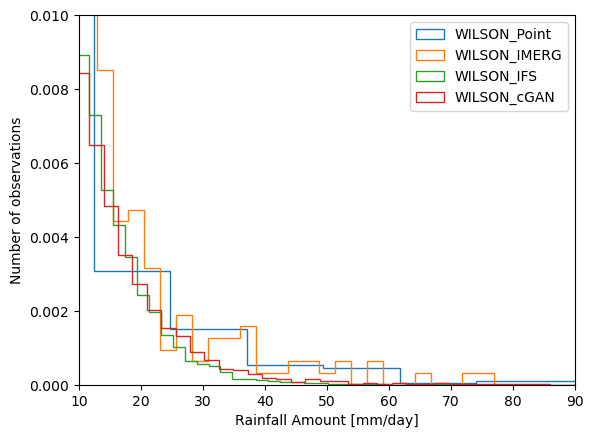

In [30]:
import matplotlib.pyplot as plt
region = 'WILSON'

idx_region =  bounding_box(region,meta[region].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)

plt.hist(ds[region].values,bins=10,density=True,histtype='step',label=region+'_Point')
plt.hist(ds_IMERG.isel({'latlon':idx_region}).Nairobi.values,bins=30,density=True,histtype='step',label=region+'_IMERG')
plt.hist(ds_IFS.isel({'latlon':idx_region}).Nairobi.values.flatten(),bins=50,density=True,histtype='step',label=region+'_IFS')
plt.hist(ds_cGAN.isel({'latlon':idx_region}).Nairobi.values.flatten(),bins=50,density=True,histtype='step',label=region+'_cGAN')
plt.xlim(10,90)
plt.ylim(0,0.01)

plt.xlabel("Rainfall Amount [mm/day]")
plt.ylabel("Number of observations")

plt.legend()


In [69]:
idx_region

array([0, 1])